#Importing essential Libraries

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
import numpy as np
#Importing some essential Libraries:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1
import torchvision

#Loading Data

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio

image_path = '/content/drive/MyDrive/DL/Datasets/train'

image_data = []
image_masks = []

#Loading images
print("Loading Training Images...")

filenames = [os.path.join(image_path, img) for img in os.listdir(image_path)]
filenames.sort()
count=0
for img in filenames:
  count += 1
  image_arr = cv2.imread(img)  #One image of dim (W, H, 3)

  #Resizing
  new_image = cv2.resize(image_arr, (220,220))  
  new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB) 
  image_data.append(new_image)
  if count%1000 ==0:
    print(count)
  
images = np.array(image_data)



#Loading Masks
image_mask_path = '/content/drive/MyDrive/DL/Datasets/train_masks'
print("Loading Training Masks...")
filenames = [os.path.join(image_mask_path, img) for img in os.listdir(image_mask_path)]
filenames.sort()
count = 0
for img in filenames:
  count += 1
  image_arr = imageio.imread(img)  #One image of dim (W, H, 3)
  
  #Resizing
  new_image = cv2.resize(image_arr, (220,220))  
  image_masks.append(new_image)
  if count%1000 ==0:
    print(count) 
  
images = np.array(image_data)
masks = np.array(image_masks)

print("Training images shape: " ,images.shape)     
print("Training Masks shape: ",masks.shape)      #Labels are grayscale Images

Loading Training Images...
1000
2000
3000
4000
5000
Loading Training Masks...
1000
2000
3000
4000
5000
Training images shape:  (5088, 220, 220, 3)
Training Masks shape:  (5088, 220, 220)


In [ ]:
masks[masks<100] = 0
masks[masks>=100] = 1.0


In [7]:
#For faster Loading above loaded images are saved as numpy array. 
load_path_images = '/content/drive/MyDrive/DL/Datasets/images_carvana.npy'
load_path_masks = '/content/drive/MyDrive/DL/Datasets/masks_carvana.npy'
images = np.load(load_path_images)
masks = np.load(load_path_masks)

Visualizing some images:

Image


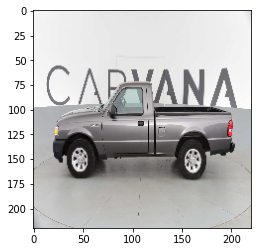

It's Mask


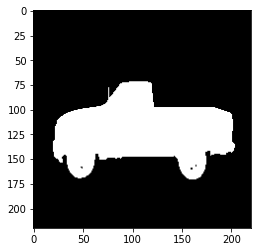

In [8]:
plt.figure(1)
print("Image")
plt.imshow(images[100], cmap= 'gray')
plt.show()
plt.figure(2)
print("It's Mask")
plt.imshow(masks[100], cmap= 'gray')
plt.show()

Checking if GPU is available

In [9]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


In [10]:
#validation dataset
val = images[5050:5080,:,:,:]
val_mask = masks[5050:5080,:,:]

In [11]:
print("Val shape: ", val.shape)
print("Val mask shape: ", val_mask.shape)

Val shape:  (30, 220, 220, 3)
Val mask shape:  (30, 220, 220)


In [12]:
#Train Dataset
images = images[0:5050]
masks = masks[0:5050]

In [13]:
print("training images shape: ", images.shape)
print("training masks shape: ", masks.shape)

training images shape:  (5050, 220, 220, 3)
training masks shape:  (5050, 220, 220)


Transferring the Images to GPU

In [14]:
images = torch.tensor(images, device = DEVICE)
masks = torch.tensor(masks, device = DEVICE)

Normalize the image

In [15]:
images = images.float()
mean = (torch.mean(images))
images = images/ mean

In [16]:
val = torch.tensor(val, device = DEVICE)
val_mask = torch.tensor(val_mask, device = DEVICE)
val = val.float()
val = val/ mean

Reshaping the Image for network to work on

In [17]:
#changing image dimension to that which is accepted by the the model
images = images.permute(0,3,1,2)

In [18]:
val = val.permute(0,3,1,2)

In [19]:
import torchvision.transforms.functional as TF

#Creating Unet Netowk architecture

##Paper: https://arxiv.org/abs/1505.04597
There is some changes as compared to orignal Unet architectures to improve the performance

In [20]:
class unet(nn.Module):

  def __init__(self, in_channels, out_channels):     #Features is the dimension of Height and Width of the image
    super(unet, self).__init__()
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

    #upsampling layers
    self.up1 = nn.ConvTranspose2d( 1024, 512, kernel_size=2, stride=2, )
    self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    
    self.up2 = nn.ConvTranspose2d( 512, 256, kernel_size=2, stride=2, )
    self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    
    self.up3 = nn.ConvTranspose2d( 256, 128, kernel_size=2, stride=2, )
    self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    
    self.up4 = nn.ConvTranspose2d( 128, 64, kernel_size=2, stride=2, )
    self.conv9 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.conv_final = nn.Conv2d(64, out_channels, 3, 1, 1)               #output channel is the no of classes
    
  def forward(self, input):

    #Downsampling Part
    out = self.conv1(input)
    out_1 = out
    out = self.pool1(out)       #()

    out = self.conv2(out)
    out_2 = out
    out = self.pool2(out)

    out = self.conv3(out)
    out_3 = out
    out = self.pool3(out)
    
    out = self.conv4(out)
    out_4 = out
    out = self.pool4(out)
    
    out = self.conv5(out)
    
    #Upsampling part
    out = self.up1(out) 
    if out_4.shape != out.shape:
      out = TF.resize(out, size= [out_4.shape[2], out_4.shape[3]])
    out = torch.cat((out_4, out), dim = 1)
    out = self.conv6(out)

    out = self.up2(out)  
    if out_3.shape != out.shape:
      out = TF.resize(out, size= [out_3.shape[2], out_3.shape[3]]) 
    out = torch.cat((out_3, out), dim = 1)
    out = self.conv7(out)

    out = self.up3(out) 
    if out_2.shape != out.shape:
      out = TF.resize(out, size= [out_2.shape[2], out_2.shape[3]])    
    out = torch.cat((out_2, out), dim = 1)
    out = self.conv8(out)

    out = self.up4(out) 
    if out_1.shape != out.shape:
      out = TF.resize(out, size= [out_1.shape[2], out_1.shape[3]])    
    out = torch.cat((out_1, out), dim = 1)
    out = self.conv9(out)

    out = self.conv_final(out)

    return out





In [21]:
model = unet(3,2).to(device = DEVICE)

In [22]:
model(images[0].reshape(1, images[0].shape[0], images[0].shape[1], images[0].shape[2])).shape

torch.Size([1, 2, 220, 220])

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        #update the weights of the model 
loss_type = torch.nn.CrossEntropyLoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 100, gamma = 0.9)   #Every 100 epochs our learning rate will be multiplied by gamma

In [24]:
np.unique(masks[70].cpu().numpy())

array([0, 1], dtype=uint8)

#Training the model using pytorch dataloader and other pytorch tools

In [25]:
from torch.utils.data import Dataset, DataLoader     #Importing Dataloader

In [26]:
class CustomImageDataset(Dataset):    #Making the class that takes the index and gives the images and it's corrosponding masks
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return images.shape[0]

    def __getitem__(self, idx):
        x_batch = self.images[idx]
        y_batch = self.masks[idx]
        return x_batch, y_batch

In [27]:
data = CustomImageDataset(images, masks)  #data is the object for the class that takes index and gives data and it's mask

In [28]:
batchsize = 14
dataloader = DataLoader(dataset= data, batch_size= batchsize, shuffle= True)

In [29]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 5.2 MB/s 


In [30]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(num_classes=2).to(DEVICE)

##Training Network

In [31]:
#Model Training
loss_graph = []
num_epochs = 10   #Here each epoch means that at each epoch the model will train once over the entire datset using sgd on small batches


for j in range(num_epochs):

  with torch.no_grad():
    model.eval()
    pred = model(val)
    pred = pred.argmax(axis= 1)
    print("Jaccard index before epoch ", j, " is: ", jaccard(pred, val_mask).cpu().item())

  model.train()
  for i, (x_batch, y_batch) in enumerate(dataloader):

    optimizer.zero_grad()
    y_pred = model(x_batch)
    y_pred = y_pred.permute(0,2,3,1)
    y_pred = y_pred.reshape(-1,2)
    y_batch = y_batch.reshape(-1)
  
    loss = loss_type(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    loss_graph.append(loss.cpu().item())

    #schedular step
    #step_lr.step()

  print("Epoch: ", j+1, ", loss is: ", loss.cpu().item())
  #print("Learning rate is: ", optimizer.state_dict()['param_groups'][0]['lr'])

Jaccard index before epoch  0  is:  0.11273189634084702
Epoch:  1 , loss is:  0.02038935199379921
Jaccard index before epoch  1  is:  0.9842565059661865
Epoch:  2 , loss is:  0.012509026564657688
Jaccard index before epoch  2  is:  0.9870830178260803
Epoch:  3 , loss is:  0.010384872555732727
Jaccard index before epoch  3  is:  0.9877358078956604
Epoch:  4 , loss is:  0.00766232842579484
Jaccard index before epoch  4  is:  0.9911600947380066
Epoch:  5 , loss is:  0.007368347141891718
Jaccard index before epoch  5  is:  0.991329550743103
Epoch:  6 , loss is:  0.008263489231467247
Jaccard index before epoch  6  is:  0.9930188655853271
Epoch:  7 , loss is:  0.006465842481702566
Jaccard index before epoch  7  is:  0.992862343788147
Epoch:  8 , loss is:  0.006197026465088129
Jaccard index before epoch  8  is:  0.9926159977912903
Epoch:  9 , loss is:  0.004778584931045771
Jaccard index before epoch  9  is:  0.8871115446090698
Epoch:  10 , loss is:  0.008962105959653854


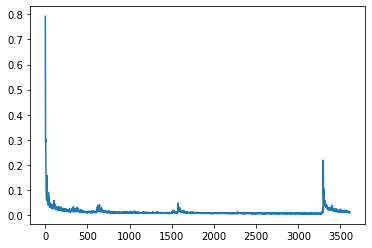

In [32]:
#Loss Graph
plt.plot(loss_graph)  
plt.show()

#Final result from the Trained Model: 

Prediction on seen data (Training data)

Predicted segmentation mask


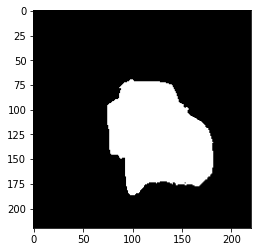

Actual mask


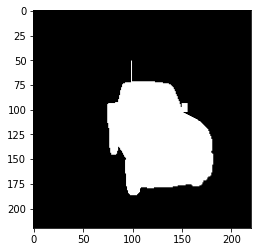

In [34]:
model.eval()
y = model(images[111].reshape(1,images.shape[1], images.shape[2], images.shape[3]))
y = y.argmax(axis= 1)
y = y.reshape(220,220)
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.detach().cpu().numpy()), cmap= 'gray')
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(masks[111].clone().cpu()), cmap= 'gray')
plt.show()

Prediction on unseen data (Validation data)

Predicted segmentation mask


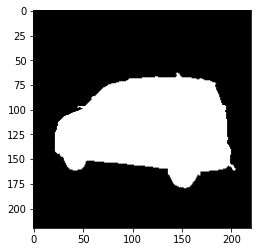

Actual mask


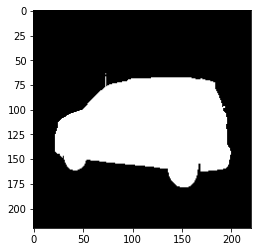

In [35]:
model.eval()
y = model(val[11].reshape(1,val.shape[1], val.shape[2], val.shape[3]))
y = y.argmax(axis= 1)
y = y.reshape(220,220)
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.detach().cpu().numpy()), cmap= 'gray')
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(val_mask[11].clone().cpu()), cmap= 'gray')
plt.show()